In [ ]:

from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
file_path = '/content/drive/My Drive/ML_Dataset/hopefully_final.csv'
df = pd.read_csv(file_path)


In [ ]:
df.head()


,User Id,Product Id,Rating,Time stamp
0,A15THVWZS6GQZY,1304622428,5,1388102400
1,A3E4N6O6WC8LEX,3227001381,5,1323216000
2,A13IIHXY0QX4Y4,535795531X,3,1356566400
3,A1X1X91COEBHVI,5357955743,5,1395014400
4,A16495HOSCEV0N,5357955832,5,1403913600


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User Id     1002 non-null   object
 1   Product Id  1002 non-null   object
 2   Rating      1002 non-null   int64 
 3   Time stamp  1002 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 31.4+ KB


In [ ]:
df.describe()


,Rating,Time stamp
count,1002.000000,1.002000e+03
mean,4.006986,1.335418e+09
std,1.691771,7.651500e+07
min,0.000000,9.826272e+08
25%,4.000000,1.324166e+09
50%,5.000000,1.363133e+09
75%,5.000000,1.383610e+09
max,5.000000,1.405210e+09


In [ ]:
df.shape

(1002, 3)

In [ ]:
df = df.drop(['Time stamp'], axis=1)

In [ ]:
df.isnull().sum()


,0
User Id,0
Product Id,0
Rating,0
Time stamp,0


In [ ]:
# !pip install implicit

In [ ]:

!pip install scikit-surprise

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# user_encoder = LabelEncoder()
# product_encoder = LabelEncoder()

# df['Encoded User Id'] = user_encoder.fit_transform(df['User Id'])
# df['Encoded Product Id'] = product_encoder.fit_transform(df['Product Id'])




In [ ]:
user_mapping = {user_id: idx for idx, user_id in enumerate(df['User Id'].unique())}
product_mapping = {product_id: idx for idx, product_id in enumerate(df['Product Id'].unique())}

df['Encoded User Id'] = df['User Id'].map(user_mapping)
df['Encoded Product Id'] = df['Product Id'].map(product_mapping)


In [ ]:
df.head()

,User Id,Product Id,Rating,Encoded User Id,Encoded Product Id
0,A15THVWZS6GQZY,1304622428,5,0,0
1,A3E4N6O6WC8LEX,3227001381,5,1,1
2,A13IIHXY0QX4Y4,535795531X,3,2,2
3,A1X1X91COEBHVI,5357955743,5,3,3
4,A16495HOSCEV0N,5357955832,5,4,4


In [ ]:
import numpy as np
from scipy.sparse import csr_matrix


n_users = len(user_mapping)
n_products = len(product_mapping)


interaction_matrix = np.zeros((n_users, n_products))


for _, row in df.iterrows():
    user_idx = row['Encoded User Id']
    product_idx = row['Encoded Product Id']
    interaction_matrix[user_idx, product_idx] = row['Rating']

interaction_matrix = csr_matrix(interaction_matrix)  # Convert to sparse matrix


In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split

# Prepare data for the Surprise library
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['Encoded User Id', 'Encoded Product Id', 'Rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2)

svd = SVD()
svd.fit(trainset)


In [ ]:
def get_top_n_recommendations(user_id, model, interaction_matrix, n=3):
    # Convert sparse matrix to dense
    interaction_matrix_dense = interaction_matrix.toarray()

    n_products = interaction_matrix_dense.shape[1]

    predictions = []
    for product_id in range(n_products):
        if interaction_matrix_dense[user_id, product_id] == 0:
            predicted_rating = model.predict(user_id, product_id).est
            predictions.append((product_id, predicted_rating))


    predictions.sort(key=lambda x: x[1], reverse=True)
    return predictions[:n]


In [ ]:


print("Available User IDs:", list(user_mapping.keys()))
user_id_input = input("Enter User ID: ")

while user_id_input not in user_mapping:
    print("Invalid User ID. Please try again.")
    user_id_input = input("Enter User ID (Original User ID, e.g., A15THVWZS6GQZY): ")

user_id = user_mapping[user_id_input]

n = int(input("Enter the number of recommendations: "))

top_n_recommendations = get_top_n_recommendations(user_id, svd, interaction_matrix, n)

print(f"\nTop {n} recommended products for User {user_id_input} (Encoded ID {user_id}):")
for product_id, predicted_rating in top_n_recommendations:

    original_product_id = list(product_mapping.keys())[list(product_mapping.values()).index(product_id)]
    print(f"Product ID: {original_product_id}, Predicted Rating: {predicted_rating:.2f}")


Available User IDs: ['A15THVWZS6GQZY', 'A3E4N6O6WC8LEX', 'A13IIHXY0QX4Y4', 'A1X1X91COEBHVI', 'A16495HOSCEV0N', 'AOJRTF5PJMIR6', 'A1HBQHOWMXOLBM', 'A1CT0SH9XKNIDY', 'A3E13GVY40E6T5', 'A1E09RWAID7HCH', 'A138ATFNJU102C', 'A024581134CV80ZBLIZTZ', 'A3FNVF412991A6', 'A05492663T95KW63BR75K', 'A00205921JHJK5X9LNP42', 'A3SP22BU1008GV', 'A10205RFE66H1R', 'A3D0SBB68TTET', 'A1HB4DFQC6ZGHW', 'A15HBNI7E4H4I2', 'A3GJFDRP3Q8GV5', 'A1RON1NZIGQNBO', 'A2FYGUHALQQYK8', 'A3LURPBMK4ZDIR', 'A1RFITZDNVIA0T', 'A15UJADUAS68JI', 'A3E1969PZ33LO9', 'A1RFBE2LHNLHPI', 'A3E2GP3Z1EGVQ8', 'A1E0IC983BZ9T5', 'AOKIUG9H8I8KU', 'A3LSRSY3F7CWPA', 'A1DGD9AGZNF6O9', 'AOGJ43H5ZZPLM', 'A1AAJGGLN1YG5Q', 'A3E3ZSEKGWFUGZ', 'A3EB7LZY4SO8S4', 'A165V5XOD0LNSR', 'A3EA0MI9BVJXBE', 'A19C4WE5N9WJLU', 'AJDANTTLD8MFD', 'A1HQT5S6EYBZ9Y', 'A3SYPIB569VQ35', 'A3FLN91OHH4WKM', 'A3SXO9YG5TLTKI', 'A3SYJB7D8UMZGL', 'A1E1GFR3WEBKV6', 'A1RG6W0BXEBST4', 'A3D1X00Y1RDY77', 'A3R14060VCWUAD', 'A3LUELTFFICUKN', 'A20DHG878IX2OE', 'A10BZV61MNLBZD', 'A1RPLQDI

In [ ]:
from surprise import accuracy

predictions = svd.test(testset)


In [ ]:
from surprise.model_selection import GridSearchCV
from surprise import SVD, Dataset, Reader
from surprise import accuracy

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['User Id', 'Product Id', 'Rating']], reader)

param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30, 40],
    'lr_all': [0.005, 0.01, 0.02],
    'reg_all': [0.02, 0.1, 0.2]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs.fit(data)

print(f"Best RMSE: {gs.best_score['rmse']:.4f}")
print(f"Best hyperparameters: {gs.best_params['rmse']}")

best_params = gs.best_params['rmse']
best_svd = SVD(**best_params)

trainset, testset = train_test_split(data, test_size=0.2)
best_svd.fit(trainset)

predictions = best_svd.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"Final RMSE: {rmse:.4f}")
print(f"Final MAE: {mae:.4f}")


Best RMSE: 1.6662
Best hyperparameters: {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}
RMSE: 1.6071
MAE:  1.2214
Final RMSE: 1.6071
Final MAE: 1.2214


In [ ]:
from surprise import accuracy

rmse = accuracy.rmse(predictions, verbose=False)
mae = accuracy.mae(predictions, verbose=False)

print("Model Performance Metrics:")
print("-" * 30)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Model Performance Metrics:
------------------------------
Root Mean Squared Error (RMSE): 1.6071
Mean Absolute Error (MAE): 1.2214


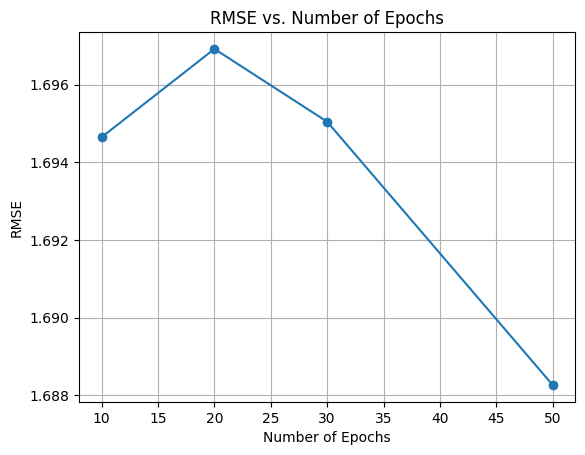

In [ ]:
from surprise import SVD
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=0.2)

# Track RMSE values
epoch_range = [10, 20, 30, 50]
rmse_values = []

for n_epochs in epoch_range:
    svd = SVD(n_factors=100, n_epochs=30, lr_all=0.01, reg_all=0.1)
    svd.fit(trainset)
    predictions = svd.test(testset)
    rmse = accuracy.rmse(predictions, verbose=False)
    rmse_values.append(rmse)


import matplotlib.pyplot as plt

plt.plot(epoch_range, rmse_values, marker='o')
plt.title('RMSE vs. Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.grid()
plt.show()


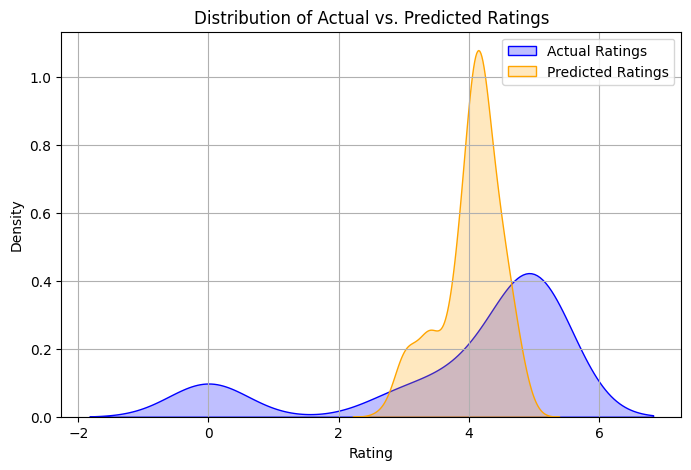

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.kdeplot(actual_ratings, label='Actual Ratings', fill=True, color='blue')  # Replace `shade` with `fill`
sns.kdeplot(predicted_ratings, label='Predicted Ratings', fill=True, color='orange', warn_singular=False)  # Handle 0 variance
plt.title("Distribution of Actual vs. Predicted Ratings")
plt.xlabel("Rating")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


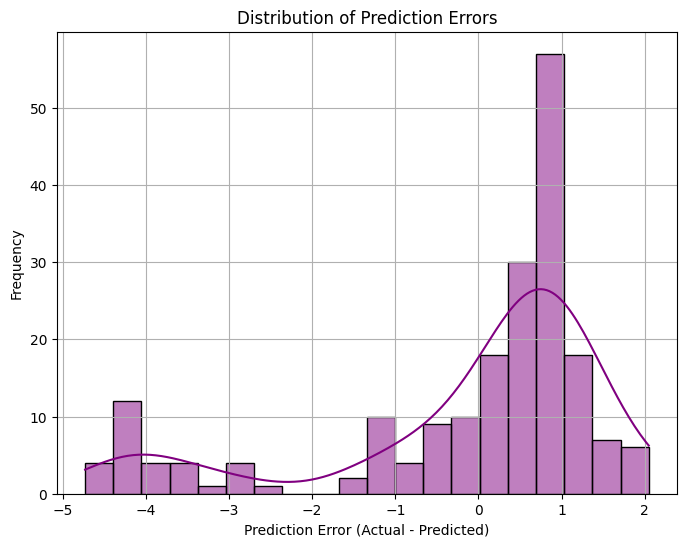

In [ ]:
errors = [actual - predicted for actual, predicted in zip(actual_ratings, predicted_ratings)]

plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=20, kde=True, color='purple')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
# from google.colab import files

# # Save the dataframe to a CSV file
# df.to_csv('product.csv', index=False)

# # Download the file
# files.download('product.csv')
